In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import re, sys
from operator import add
!pip install pyspark
import pyspark
from matplotlib import pyplot as plt
from pyspark.sql import Row

from pyspark.sql import SparkSession
!pip install graphframes
from graphframes import GraphFrame
import networkx as nx


import json
import zipfile
import os
import zipfile
from pprint import pprint


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 34 kB/s 
     |████████████████████████████████| 199 kB 43.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=6a3d1698ba6db14dbb13a48d36ba4aa7a445b9488eec80c72d8fa2949b939107
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 4.2 MB/s 


In [ ]:
os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages graphframes:graphframes:0.8.0-spark3.0-s_2.12 pyspark-shell"
)
spark = SparkSession.builder \
                    .appName("IMDB Dataset Project") \
                    .config("spark.memory.offHeap.enabled",True) \
                    .config("spark.memory.offHeap.size","16g") \
                    .config("spark.jars.packages", "graphframes:graphframes:0.8.0-spark3.0-s_2.12") \
                    .getOrCreate()
spark

In [ ]:
api_token = {"username":"amirrezadashtigenave","key":"c66368dee306274ca671fba6e60fb28b"}

kaggle_path = '/root/.kaggle/'
dataset_path = './ashirwadsangwan/'
# Check whether the specified path exists or not
if not os.path.exists(kaggle_path):
  # Create a new directory because it does not exist 
  os.makedirs(kaggle_path)
  print("The new directory is created!")

with open(kaggle_path + 'kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

if not os.path.exists(dataset_path):
  # Create a new directory because it does not exist 
  os.makedirs(dataset_path)
  print("The new directory is created!")

The new directory is created!
100% 1.01G/1.01G [00:06<00:00, 159MB/s]
100% 1.01G/1.01G [00:06<00:00, 180MB/s]
The new directory is created!


In [ ]:
with zipfile.ZipFile('./imdb-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./ashirwadsangwan/')

In [ ]:
title_basics = spark.read.csv("./ashirwadsangwan/title.basics.tsv/data.tsv", sep=r'\t', header=True)
print(title_basics.count())

9235180


/usr/local/lib/python3.7/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


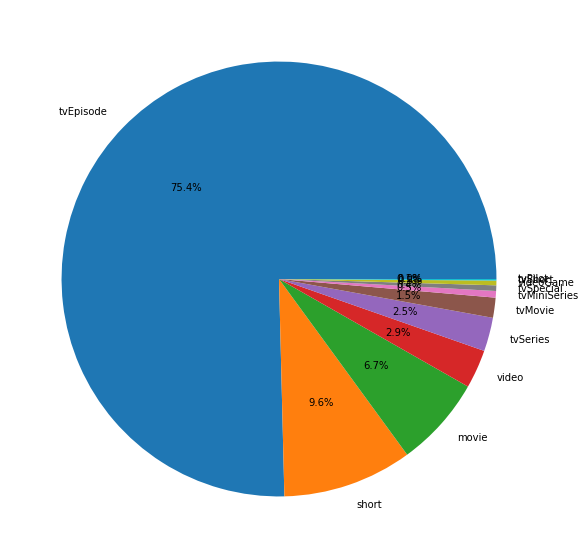

In [ ]:
fig = plt.figure(figsize =(12, 10))
plt.pie(title_basics.pandas_api().titleType.value_counts().values\
        ,autopct='%1.1f%%'\
        ,labels = title_basics.pandas_api().titleType.value_counts().keys().to_numpy())
plt.show()

In [ ]:
nodes = title_basics.rdd.map(lambda x: (x[0], x[1]))
# nodes = title_basics.rdd.map(lambda x: (x[2], x[1]))
nodes = nodes.filter(lambda x: x[1] == "movie").map(lambda x: x[0])
number_of_nodes = nodes.count()

In [ ]:
title_principals = spark.read.csv("./ashirwadsangwan/title.principals.tsv/data.tsv", sep=r'\t', header=True)

In [ ]:
title_principals.createOrReplaceTempView("title_principals")
title_basics.createOrReplaceTempView("title_basics")
# sql_df = spark.sql("Select t1.*, t2.* from title_principals as t1 INNER JOIN title_basics as t2 ON t1.tconst = t2.tconst where t2.titleType= 'movie'")
sql_df = spark.sql("Select t1.*, t2.* from title_principals as t1 INNER JOIN title_basics as t2 ON t1.tconst = t2.tconst where t2.titleType= 'movie' and t2.startYear > '2021'")

In [ ]:
cast_id_to_movie_list = sql_df.rdd.map(lambda x: (x[2],x[0], x[3]))\
                   .filter(lambda x: x[2] == "actor" or x[2] == "actress")\
                   .map(lambda x: (x[0],x[1]))\
                   .groupByKey()\
                   .map(lambda x : (x[0], list(x[1])))

# cast_id_to_movie_list = sql_df.rdd.map(lambda x: (x[2],x[8], x[3]))
#                    .filter(lambda x: x[2] == "actor" or x[2] == "actress")\
#                    .map(lambda x: (x[0],x[1]))\
#                    .groupByKey()\
#                    .map(lambda x : (x[0], list(x[1])))\
# print(cast_id_to_movie_list.take(2))

In [ ]:
movie_id_to_movie_id = cast_id_to_movie_list.map(lambda x: [(a, b) for a in x[1] for b in x[1] if a!=b]).flatMap(lambda x: x).distinct()
# movie_id_to_movie_id.take(5)

<h3> Creating GraphFrame object </h3>

In [ ]:
row = Row("id")
v = nodes.map(row).toDF()
e = movie_id_to_movie_id.toDF(["src", "dst"]).dropDuplicates()
g = GraphFrame(v, e)  

/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:149: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  "DataFrame.sql_ctx is an internal property, and will be removed "


<h3>Calculating pagerank using GraphFrames package</h3>


In [ ]:
graphframes_pagerank_results = g.pageRank(resetProbability=0.15, maxIter=10)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [ ]:
sum_of_graphframes_pagerank_values = graphframes_pagerank_results.vertices.rdd.map(lambda x: x[1]).reduce(lambda x,y: x+y)

In [ ]:
print(sum_of_graphframes_pagerank_values)
print(number_of_nodes)

621671.0000047298
621671


<h3>Showing most important nodes:</h3>


In [ ]:
graphframes_pagerank_results.vertices.orderBy("pagerank", ascending=False).show(20)

+----------+------------------+
|        id|          pagerank|
+----------+------------------+
| tt4745692| 38.23932047324526|
|tt11916562| 37.96605637052104|
| tt3886736|36.075095123569604|
| tt5918332|33.744758026622975|
|tt11075800|  32.8799369109428|
|tt13114794|32.490416787645444|
| tt4968564| 32.34453827996746|
|tt21215814| 30.90191892612437|
|tt12399882|30.057789061238935|
|tt10765798| 29.88557342914089|
|tt11776266|29.875470296237943|
|tt12126628|29.325625096257436|
| tt9512094| 29.26542983740735|
|tt14132588|29.231980102100806|
|tt14416808|28.800044447540316|
|tt13950392| 28.65657812190551|
|tt12709774|28.503183622549514|
|tt10921118| 28.41203063901606|
| tt3643390|27.979113199531547|
|tt11416582|27.926737418077305|
+----------+------------------+
only showing top 20 rows



<h3>Least important nodes:</h3>

In [ ]:
graphframes_pagerank_results.vertices.orderBy("pagerank", ascending=True).show(20)

+---------+------------------+
|       id|          pagerank|
+---------+------------------+
|tt0002588|0.7807932888249809|
|tt0002591|0.7807932888249809|
|tt0005209|0.7807932888249809|
|tt0005605|0.7807932888249809|
|tt0005617|0.7807932888249809|
|tt0005912|0.7807932888249809|
|tt0006204|0.7807932888249809|
|tt0007169|0.7807932888249809|
|tt0007694|0.7807932888249809|
|tt0008522|0.7807932888249809|
|tt0008893|0.7807932888249809|
|tt0009455|0.7807932888249809|
|tt0009962|0.7807932888249809|
|tt0010060|0.7807932888249809|
|tt0010179|0.7807932888249809|
|tt0010898|0.7807932888249809|
|tt0011011|0.7807932888249809|
|tt0011031|0.7807932888249809|
|tt0011477|0.7807932888249809|
|tt0012139|0.7807932888249809|
+---------+------------------+
only showing top 20 rows



In [ ]:
graphframes_pagerank_results.vertices.show(20)

+---------+------------------+
|       id|          pagerank|
+---------+------------------+
|tt0002588|0.7807932888249809|
|tt0002591|0.7807932888249809|
|tt0005209|0.7807932888249809|
|tt0005605|0.7807932888249809|
|tt0005617|0.7807932888249809|
|tt0005912|0.7807932888249809|
|tt0006204|0.7807932888249809|
|tt0007169|0.7807932888249809|
|tt0007694|0.7807932888249809|
|tt0008522|0.7807932888249809|
|tt0008893|0.7807932888249809|
|tt0009455|0.7807932888249809|
|tt0009962|0.7807932888249809|
|tt0010060|0.7807932888249809|
|tt0010179|0.7807932888249809|
|tt0010898|0.7807932888249809|
|tt0011011|0.7807932888249809|
|tt0011031|0.7807932888249809|
|tt0011477|0.7807932888249809|
|tt0012139|0.7807932888249809|
+---------+------------------+
only showing top 20 rows



<h3>Now, we build the graph for the second time, but this time we are using the ***networkx*** library. The purpose is to calculate the pagerank algorithm with a different library to observe and compare the results.</h3>

In [ ]:
myGraph = nx.Graph()
myGraph = nx.from_pandas_edgelist(e.toPandas(), 'src', 'dst')

<h3>Calculating pagerank for the second time using networkx library.</h3>

In [ ]:
networkx_pagerank_results = nx.pagerank(myGraph, alpha=0.85, max_iter=10)

In [ ]:
sum_of_graphframes_pagerank_values = sum(networkx_pagerank_results.values())
print(sum_of_graphframes_pagerank_values)

1.0000000000000613


In [ ]:
sorted_pagerank_results = dict(sorted(networkx_pagerank_results.items(), key=lambda item: item[1], reverse=True))
pprint( list(sorted_pagerank_results.items())[:20])

[('tt4745692', 0.00021239229856578578),
 ('tt3886736', 0.0002054649670807243),
 ('tt11916562', 0.0002052068712376638),
 ('tt5918332', 0.00018579393913067225),
 ('tt11075800', 0.00017797113283865663),
 ('tt13114794', 0.00017582846194369762),
 ('tt21215814', 0.00017311725527633287),
 ('tt11776266', 0.00016987458628166713),
 ('tt4968564', 0.00016924596377096228),
 ('tt12399882', 0.000168091998850165),
 ('tt10765798', 0.00016524404228879835),
 ('tt6496598', 0.00015846373914568432),
 ('tt8380948', 0.00015834931070185174),
 ('tt12126628', 0.00015794911173343192),
 ('tt13498286', 0.00015729302948292142),
 ('tt9512094', 0.00015653796786906286),
 ('tt14132588', 0.00015306744895348653),
 ('tt10921118', 0.0001529668517218255),
 ('tt12709774', 0.00015231507044327476),
 ('tt16968500', 0.00015214858289699788)]


<h3>As it is shown, the results of the algorithms are similar.</h3>

<h3> This function gets an nx.graph object and a list of pageranks as arguments and plots the graph.</h3>

In [ ]:
def plot_graph(graph, page_ranks):
    pos = nx.random_layout(graph)
    plt.figure(3,figsize=(100,100)) 
    nx.draw(graph,node_color=list(page_ranks.values()), cmap=plt.cm.coolwarm, with_labels=True, node_size=5000)
    plt.savefig("Graph.png", format="PNG")


<h2>In this step,we are going to plot a small sample of the original graph with a cool-warm color map that shows the value of pagerank.<h2>
<br>
<h3>In the generated image below, nodes(movies) with more connecting edges are warmer.</h3>

In [ ]:
myGraph.remove_edges_from(list(myGraph.edges)[100:]) # Keeping only 100 edges
print(myGraph.number_of_edges())
myGraph.remove_nodes_from(list(myGraph.nodes)[100:]) # Keeping only 100 nodes
print(myGraph.number_of_nodes())
pr2 = nx.pagerank(myGraph, alpha=0.85) # calculating the pagerank on the small graph
plot_graph(myGraph, pr2)

100
100


In [ ]:
def compute_distance(old_vector,new_vector):
    old_vector = list(old_vector.values())
    new_vector = list(new_vector.values())
    result = sum([(a - b)**2 for a, b in zip(old_vector, new_vector)])
    print(result)
    return result

In [ ]:
def compute_page_rank(edges_rdd, nodes_count, damping_factor: float = 0.85, max_iter: int = 10, tolerance = 10e-10):
    out_degree = edges_rdd.countByKey()
    M = edges_rdd.map(lambda x:(x[0],x[1],1/out_degree[x[0]]))
    M_hat = M.map(lambda x: (x[0], x[1], damping_factor * x[2] + (1 - damping_factor) / nodes_count))
    MT = M_hat.map(lambda x: (x[1],x[0],x[2]))
    vector = dict(MT.map(lambda x: (x[0],1/(nodes_count))).collect())
    old_vector = dict(MT.map(lambda x: (x[0],1)).collect())
    i=1
    while i <= max_iter and compute_distance(old_vector, vector) >= tolerance:
        new_vector = MT.map(lambda x:(x[0],(x[2]*vector[x[1]])))\
                      .reduceByKey(lambda x,y: x+y)
        old_vector = vector
        vector = dict(new_vector.map(lambda x: (x[0], x[1])).collect())
        i+=1
    return vector

In [ ]:
result = compute_page_rank(movie_id_to_movie_id, number_of_nodes)

30799.90091228552
2.4099836624239983e-08
8.64826011396898e-09
1.9261069406884327e-09
1.4945421885593404e-09
8.062252280923043e-10


In [ ]:
my_page_rank = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
pprint( list(my_page_rank.items())[:20])

[('tt4745692', 6.383337056910311e-06),
 ('tt11916562', 6.285756868348108e-06),
 ('tt3886736', 5.8678487190147665e-06),
 ('tt5918332', 5.6092334120416944e-06),
 ('tt11075800', 5.42913043992419e-06),
 ('tt13114794', 5.333557021580469e-06),
 ('tt4968564', 5.310322077615274e-06),
 ('tt21215814', 4.9918861760788734e-06),
 ('tt12399882', 4.981783306429104e-06),
 ('tt11776266', 4.928499648374616e-06),
 ('tt10765798', 4.927770136535122e-06),
 ('tt12126628', 4.916566644380596e-06),
 ('tt14132588', 4.7820753726721456e-06),
 ('tt9512094', 4.781046654792378e-06),
 ('tt14416808', 4.698772644506343e-06),
 ('tt13950392', 4.683919492478915e-06),
 ('tt10921118', 4.68209326920864e-06),
 ('tt12709774', 4.667448046593564e-06),
 ('tt11416582', 4.605245397590822e-06),
 ('tt3643390', 4.583423275970704e-06)]


In [ ]:
def compute_similarity(a, b, threshold: int = 4):
    total = 0
    for item in a:
        if item in b:
            for i in range(0,threshold):
                if a.index(item) == abs((i - b.index(item))) or a.index(item) == (i + b.index(item)):
                    total +=1
                    break
    return total/len(a)

In [ ]:
a = graphframes_pagerank_results.vertices.orderBy("pagerank", ascending=False).rdd.map(lambda x: x[0]).take(20)
b = list(my_page_rank.keys())[:20]

In [ ]:
compute_similarity(a, b, 2)

1.0